# Mass-Spring-Damper System: Postprocessing the DeepONet

In [1]:
### Importing Libraries

import sys
print(sys.version)
import os
import time


### Defining WORKSPACE_PATH

# WORKSPACE_PATH = os.environ['WORKSPACE_PATH']
WORKSPACE_PATH = os.path.join(os.getcwd(), '../../../../../../')
ROMNet_fld     = os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/')

### Importing External Libraries

import numpy                             as np
import pandas                            as pd
import tensorflow                        as tf

### Importing Matplotlib and Its Style

import matplotlib.pyplot                 as plt
import matplotlib.cm                     as cm
import matplotlib.animation              as animation

#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/presentation.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/zoomed.mplstyle'))
plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_1column.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_2columns.mplstyle'))


from scipy.integrate import solve_ivp
import pyDOE
from PCAfold         import PCA          as PCAA


import romnet                            as rmnt

3.9.12 (main, Mar 26 2022, 15:51:13) 
[Clang 12.0.0 (clang-1200.0.32.29)]


Missing colon in file PosixPath('/Users/sventur/.matplotlib/stylelib/paper_2columns.mplstyle'), line 1 ('f#### MATPLOTLIBRC FORMAT')


## Defining Input Data

In [2]:
# path_to_run_fld = os.path.join(WORKSPACE_PATH, 'ROMNet/Rect_50Instants_Rot/DeepONet/Run_2/')
# RotFlg      = True
# TransFlg    = False
# ScaleFlg    = False

# path_to_run_fld = os.path.join(WORKSPACE_PATH, 'ROMNet/Rect_50Instants_Trans/DeepONet/Run_1/')
# RotFlg      = False
# TransFlg    = True
# ScaleFlg    = False

# path_to_run_fld = os.path.join(WORKSPACE_PATH, 'ROMNet/Rect_50Instants_RotTrans/DeepONet/Run_1/')
# RotFlg      = True
# TransFlg    = True
# ScaleFlg    = False

path_to_run_fld = os.path.join(WORKSPACE_PATH, 'ROMNet/Rect_500Instants_TransRotScale_Diff/DeepONet/Run_12/')
RotFlg      = True
TransFlg    = True
ScaleFlg    = True

FigDir          = os.path.join(WORKSPACE_PATH, '../Desktop/Paper_Figures_DeepONet_TEMP/')


TrainingCases   = [0]#[0,2,4,6,8]
TestCases       = [0,2,4]#[0,2]

NSamples        = 1

LineVec         = ['-',':','--','.-']*10
ColorVec        = ['#190707', '#dd3232', '#0065a9', '#348a00','#985396','#f68b69']

In [3]:
t0   = 0.
tEnd = 10.

In [4]:
Theta0  = 0./180*np.pi
w_Theta = 36./180*np.pi

w_Psi = 50./180*np.pi
ca    = 0.5
cx0   = 1.
cy0   = -0.5

lx0   = 3.
ly0   = 2.

xMin    = -10.
xMax    = 10.
yMin    = -10.
yMax    = 10.

v_zz  = 0.2
zz0   = 1.

## Loading ROMNet's Input Data File

In [5]:
print("\n[ROMNet]: Reading Input File from: ", path_to_run_fld)
sys.path.insert(0, path_to_run_fld)

print("\n[ROMNet]: Keep Loading Modules and Functions...")
from ROMNet_Input import inputdata

print("\n[ROMNet]: Initializing Input ...")
InputData               = inputdata(WORKSPACE_PATH)


InputData.InputFilePath = path_to_run_fld+'/ROMNet_Input.py'
InputData.train_int_flg = 0
InputData.path_to_run_fld  = path_to_run_fld


[ROMNet]: Reading Input File from:  /Users/sventur/WORKSPACE/ROMNet/romnet/scripts/postprocessing/Rect/DeepONet/../../../../../../ROMNet/Rect_500Instants_TransRotScale_Diff/DeepONet/Run_12/

[ROMNet]: Keep Loading Modules and Functions...

[ROMNet]: Initializing Input ...


## Loading Tensorflow's Model for the Network 

In [6]:
surrogate_type = InputData.surrogate_type
if (surrogate_type == 'FNN-SourceTerms'):
    surrogate_type = 'FNN'

Net   = getattr(rmnt.nn, surrogate_type)

model = rmnt.model.Model_TF(InputData)

if (InputData.phys_system is not None):
    System = getattr(rmnt.pinn.system, InputData.phys_system)
    system = System(InputData)
    
model.build(InputData, None, Net, system)#, loadfile_no='000027')

NN    = model.net


[ROMNet - model_tf.py    ]:   Initializing the ML Model

[ROMNet - model_tf.py    ]:   Building the ML Model

[ROMNet - deeponet.py               ]:   Constructing Deep Operator Network: 
[ROMNet - system_of_components.py   ]:     Mapping Branch-to-Trunk (i.e., self.branch_to_trunk Object):  [0]
[ROMNet - system_of_components.py   ]:     Constructing System of Components: DeepONet
[ROMNet - component.py              ]:       Constructing Component: Branch
[ROMNet - sub_component.py          ]:         Constructed Sub-Component: Main with Layers:       ListWrapper([<keras.layers.core.dense.Dense object at 0x163cb0f10>, <keras.layers.core.dense.Dense object at 0x163ca8b20>, <keras.layers.core.dense.Dense object at 0x163d18e50>])
[ROMNet - component.py              ]:       Constructing Component: Shift
[ROMNet - sub_component.py          ]:         Constructed Sub-Component: Main with Layers:       ListWrapper([<keras.layers.core.dense.Dense object at 0x163c76490>, <keras.layers.core.dr

## Evaluating DeepONet on Test Data

In [7]:
input_vars  = model.net.input_vars
trunk_vars  = InputData.input_vars['DeepONet']['Trunk']
branch_vars = InputData.input_vars['DeepONet']['Branch']

In [8]:
# plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/heavy.mplstyle'))

# Nx   = 300
# Ny   = 300

# t0      = 4.5
# tEnd    = 5.5
# Nt      = 5
    
# tVec    = np.linspace(t0,tEnd,Nt)
# for it, t in enumerate(tVec):
#     print('t=',t)
 
#     if (RotFlg == True):
#         #Theta = Theta0 + w_Theta*t
#         Theta = Theta0 + np.cos(t/10.*(4*np.pi)+2.)*np.pi
#     else:
#         Theta = Theta0
        
#     if (TransFlg == True):
#         Psi   = t*w_Psi
#         cr    = ca * Psi
#         cx    = cx0 + cr * np.cos(Psi)
#         cy    = cy0 + cr * np.sin(Psi)  
#     else:
#         cx    = 0.
#         cy    = 0.
        
#     if (ScaleFlg == True):
#         lx    = (np.cos(t/10.*360. / 180.*np.pi)+2.)*lx0
#         ly    = (np.cos(t/10.*360. / 180.*np.pi)+2.)*ly0
#     else:
#         lx    = lx0*2 
#         ly    = ly0*2 
    
#     zz    = zz0 + t*v_zz

    
#     Mat       = np.zeros((Nx,Ny))
#     InputPred = np.zeros((Nx*Ny,3))
    
#     x    = np.linspace(xMin,xMax,Nx)
#     y    = np.linspace(yMin,yMax,Ny)

#     i    = 0
#     for ix, x_ in enumerate(x):
#         for iy, y_ in enumerate(y):
#             xrot_      = x_*np.cos(Theta) + y_*np.sin(Theta)
#             yrot_      = x_*np.sin(Theta) - y_*np.cos(Theta)

#             zx         = np.tanh((xrot_-cx+lx/2)*10.) - np.tanh((xrot_-cx-lx/2)*10.)
#             zy         = np.tanh((yrot_-cy+ly/2)*10.) - np.tanh((yrot_-cy-ly/2)*10.)  
            
#             Mat[ix,iy] = np.exp(zx+zy)*zz
            
#             InputPred[i,0] = t
#             InputPred[i,1] = x_
#             InputPred[i,2] = y_

#             i+=1
            
#     InputPred = pd.DataFrame(InputPred, columns=['t','x','y'])
#     yMat      = model.predict(InputPred)

    
# #     fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,12))
    
# #     ax1.imshow((Mat).reshape(Nx,Ny), animated=True, origin='lower', cmap=cm.turbo, extent=([xMin, xMax, yMin, yMax]))
# #     ax1.set_xlabel('x')
# #     ax1.set_ylabel('y')
    
# #     ax2.imshow((yMat).reshape(Nx,Ny), animated=True, origin='lower', cmap=cm.turbo, extent=([xMin, xMax, yMin, yMax]))
# #     ax2.set_xlabel('x')
# #     ax2.set_yticks([])

#     fig = plt.figure()
#     plt.imshow((Mat).reshape(Nx,Ny), origin='lower', cmap=cm.turbo, extent=([xMin, xMax, yMin, yMax]))
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.savefig(path_to_run_fld+'/Figures/XRec_t'+str(t)+'_Orig.pdf', format='pdf', bbox_inches='tight')
    
#     fig = plt.figure()
#     plt.imshow((yMat).reshape(Nx,Ny), origin='lower', cmap=cm.turbo, extent=([xMin, xMax, yMin, yMax]))
#     plt.xlabel('x')
#     plt.ylabel('y')
#     plt.savefig(path_to_run_fld+'/Figures/XRec_t'+str(t)+'_DeepOnet.pdf', format='pdf', bbox_inches='tight')

In [9]:
# plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_1column.mplstyle'))

# Nx   = 300
# Ny   = 300

# tVec = np.linspace(0,10,4)
# for it, t in enumerate(tVec):
#     print('t=', t)
    
#     if (RotFlg == True):
#         #Theta = Theta0 + w_Theta*t
#         Theta = Theta0 + np.cos(t/10.*(4*np.pi)+2.)*np.pi
#     else:
#         Theta = Theta0
        
#     if (TransFlg == True):
#         Psi   = t*w_Psi
#         cr    = ca * Psi
#         cx    = cx0 + cr * np.cos(Psi)
#         cy    = cy0 + cr * np.sin(Psi)  
#     else:
#         cx    = 0.
#         cy    = 0.
        
#     if (ScaleFlg == True):
#         lx    = (np.cos(t/10.*360. / 180.*np.pi)+2.)*lx0
#         ly    = (np.cos(t/10.*360. / 180.*np.pi)+2.)*ly0
#     else:
#         lx    = lx0*2 
#         ly    = ly0*2 
    
#     zz    = zz0 + t*v_zz

    
#     InputPred = np.zeros((Nx,3))
#     yData     = np.zeros(Nx)
#     x  = np.linspace(-10,10,Nx)
#     y_ = 0.
#     i  = 0
#     for ix, x_ in enumerate(x):
#         InputPred[i,0] = t
#         InputPred[i,1] = x_
#         InputPred[i,2] = y_
#         xrot_          = x_*np.cos(Theta) + y_*np.sin(Theta)
#         yrot_          = x_*np.sin(Theta) - y_*np.cos(Theta)
        
#         zx         = np.tanh((xrot_-cx+lx/2)*10.) - np.tanh((xrot_-cx-lx/2)*10.)
#         zy         = np.tanh((yrot_-cy+ly/2)*10.) - np.tanh((yrot_-cy-ly/2)*10.)  
            
#         yData[i]   = np.exp(zx+zy)*zz
            
#         i+=1
            
#     InputPred = pd.DataFrame(InputPred, columns=['t','x','y'])
    
#     yMat = model.predict(InputPred)
    
#     plt.figure()
#     plt.plot(x, yData, color=ColorVec[it])
#     plt.plot(x, yMat, ':', color=ColorVec[it])
#     plt.xlabel('x')
#     plt.ylabel('z')
#     plt.savefig(path_to_run_fld+'/Figures/XSlice_t'+str(t)+'_DeepOnet.pdf', format='pdf', bbox_inches='tight')

In [10]:
# plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/video.mplstyle'))

# img    = [] # some array of images
# frames = [] # for storing the generated images
# fig    = plt.figure(figsize=(10,8))

# Nx      = 100
# Ny      = 100

# t0      = 0.
# tEnd    = 10.
# Nt      = 20
    
# tVec    = np.linspace(t0,tEnd,Nt)
# for it, t in enumerate(tVec):
#     print('t=',t)
     
#     if (RotFlg == True):
#         #Theta = Theta0 + w_Theta*t
#         Theta = Theta0 + np.cos(t/10.*(4*np.pi)+2.)*np.pi
#     else:
#         Theta = Theta0
        
#     if (TransFlg == True):
#         Psi   = t*w_Psi
#         cr    = ca * Psi
#         cx    = cx0 + cr * np.cos(Psi)
#         cy    = cy0 + cr * np.sin(Psi)  
#     else:
#         cx    = 0.
#         cy    = 0.
        
#     if (ScaleFlg == True):
#         lx    = (np.cos(t/tEnd*360. / 180.*np.pi)+2.)*lx0
#         ly    = (np.cos(t/tEnd*360. / 180.*np.pi)+2.)*ly0
#     else:
#         lx    = lx0*2 
#         ly    = ly0*2 
    
#     zz    = zz0 + t*v_zz

#     InputPred = np.zeros((Nx*Ny,3))
    
#     x    = np.linspace(xMin,xMax,Nx)
#     y    = np.linspace(yMin,yMax,Ny)

#     i    = 0
#     for ix, x_ in enumerate(x):
#         for iy, y_ in enumerate(y):
#             xrot_      = x_*np.cos(Theta) + y_*np.sin(Theta)
#             yrot_      = x_*np.sin(Theta) - y_*np.cos(Theta)

#             zx         = np.tanh((xrot_-cx+lx/2)*10.) - np.tanh((xrot_-cx-lx/2)*10.)
#             zy         = np.tanh((yrot_-cy+ly/2)*10.) - np.tanh((yrot_-cy-ly/2)*10.)  
                        
#             InputPred[i,0] = t
#             InputPred[i,1] = x_
#             InputPred[i,2] = y_

#             i+=1
            
#     InputPred = pd.DataFrame(InputPred, columns=['t','x','y'])
#     yMat      = model.predict(InputPred)
    

#     im     = plt.imshow((yMat).reshape(Nx,Ny), animated=True, origin='lower', cmap=cm.turbo, extent=([xMin, xMax, yMin, yMax]))
#     plt.xlabel('x')
#     plt.ylabel('y')
#     frames.append([im])
    
# ani = animation.ArtistAnimation(fig, frames, interval=5000, blit=True, repeat_delay=50000)
# writergif = animation.PillowWriter(fps=30)
# ani.save(path_to_run_fld+'/Figures/Video.gif',writer=writergif)

## Plotting Loss Histories

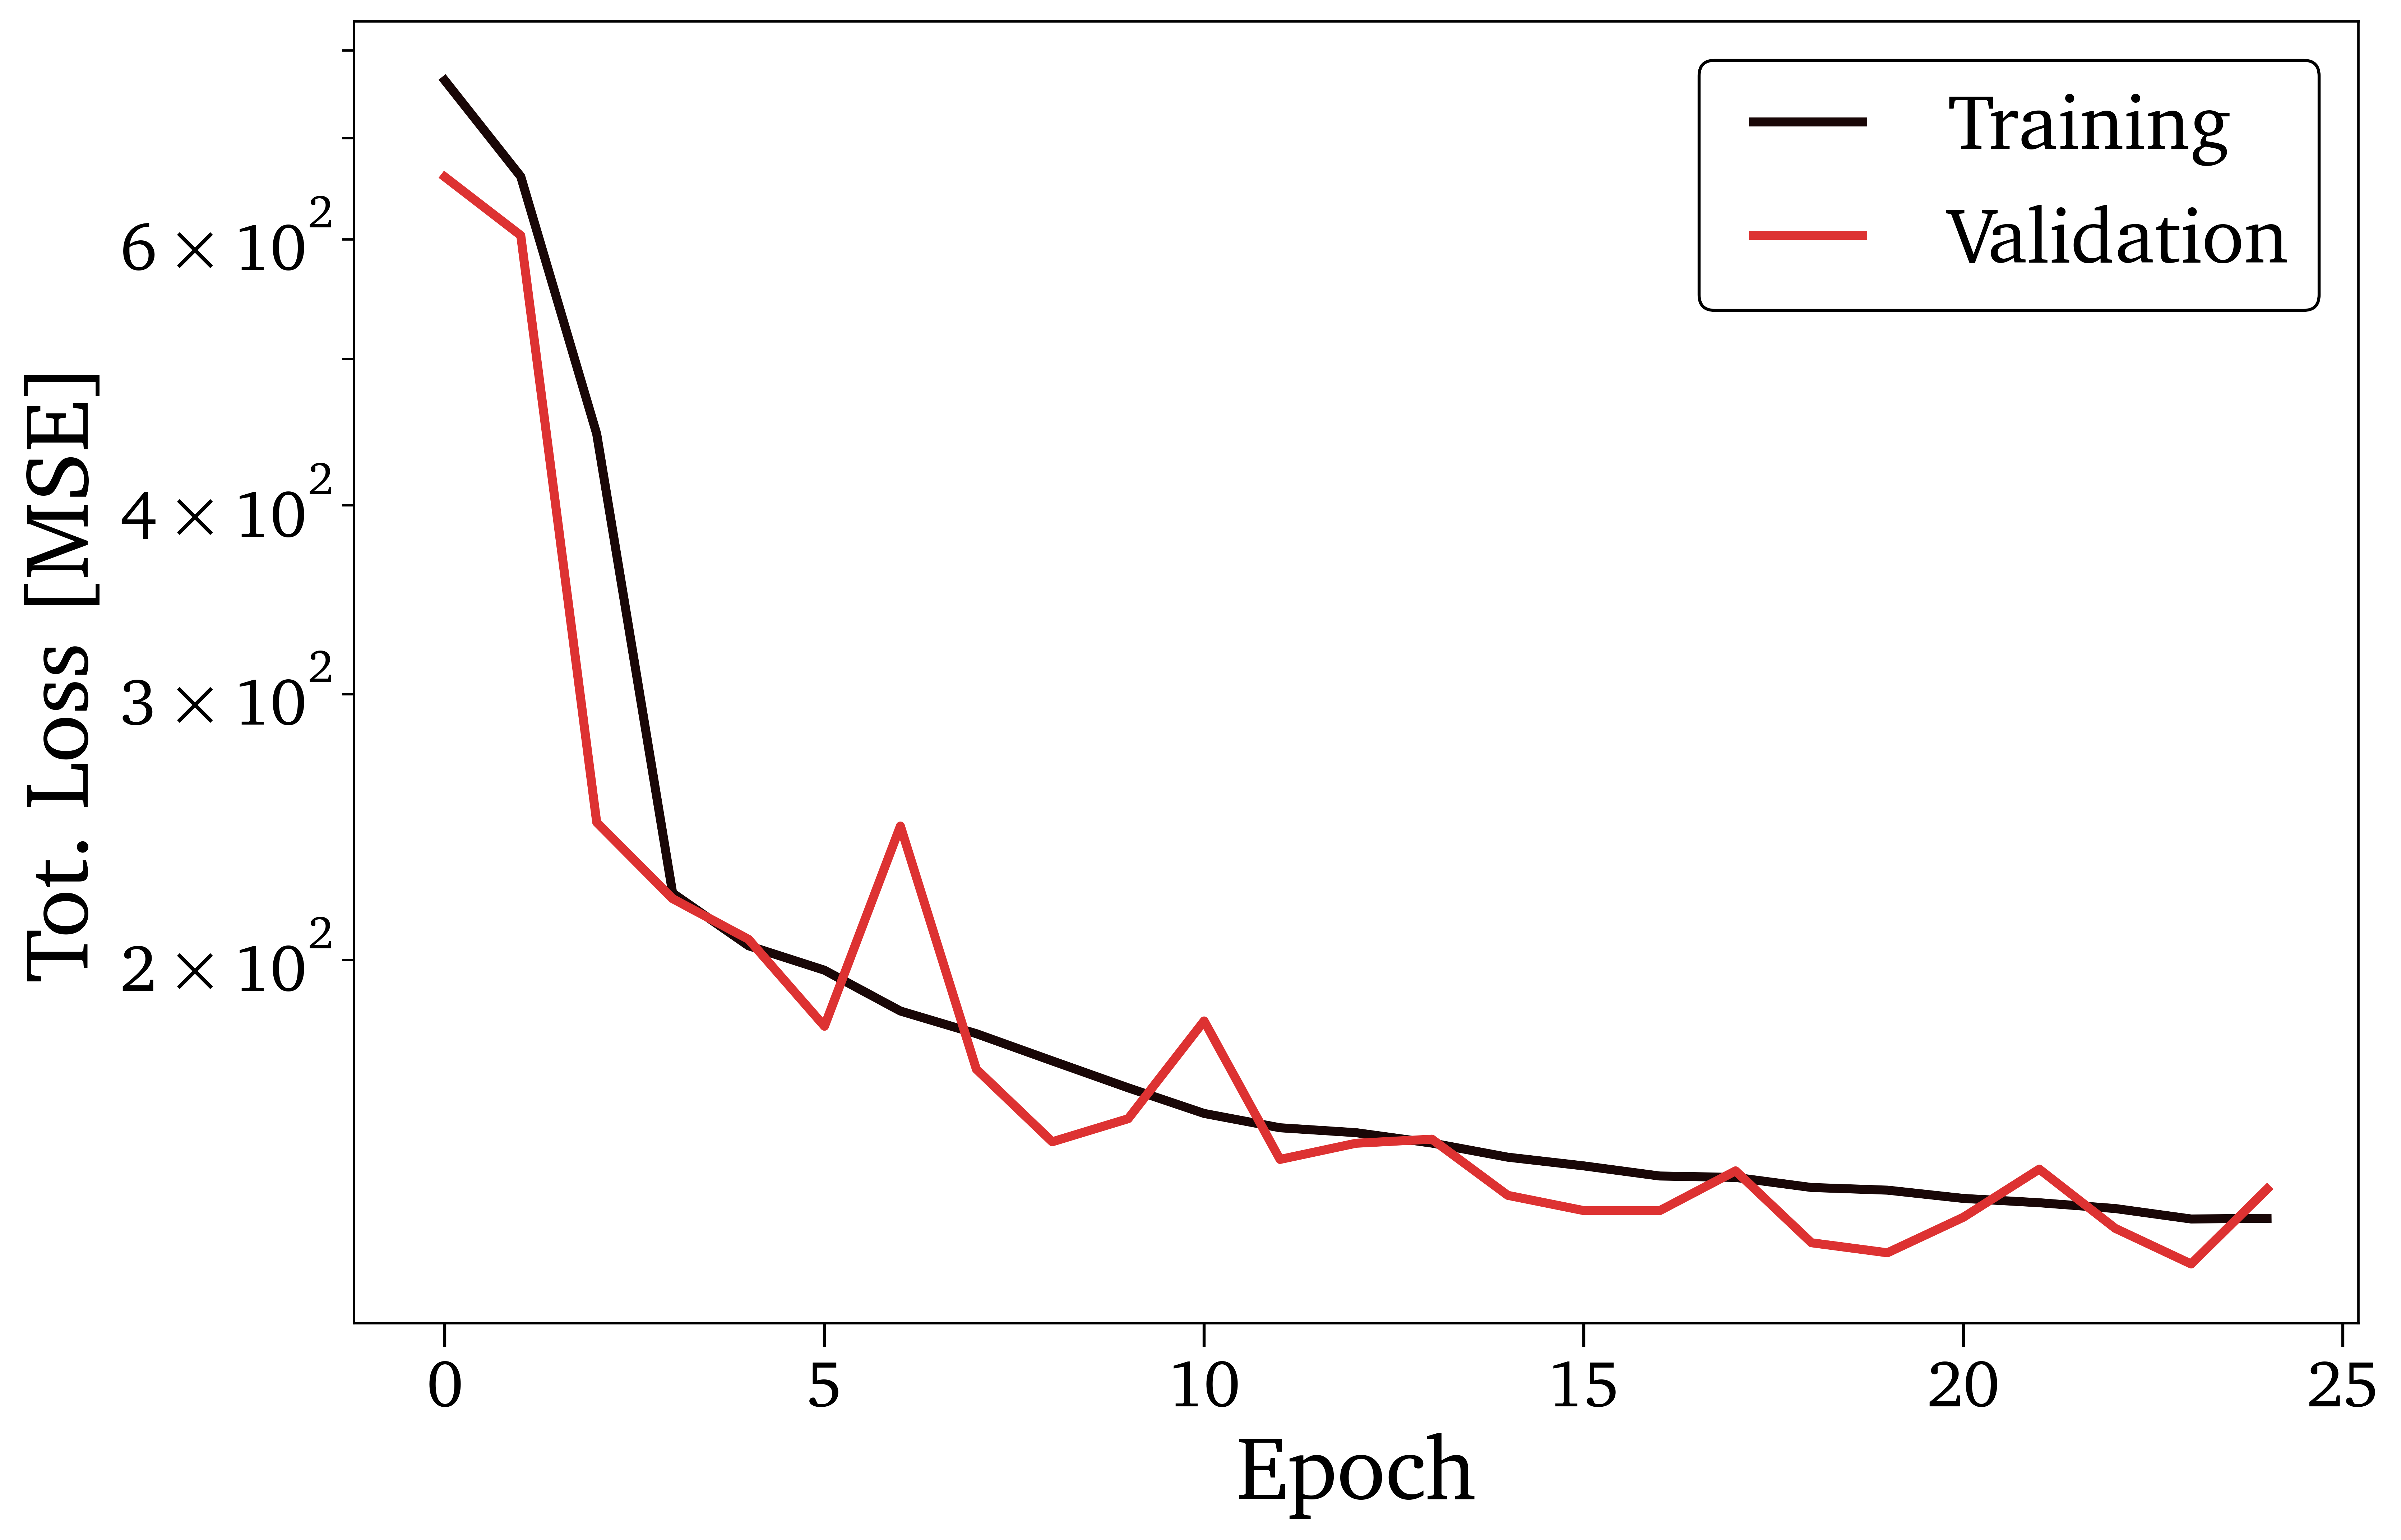

In [ ]:
plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_1column.mplstyle'))

Data = pd.read_csv(path_to_run_fld+'/Training/History.csv')

fig  = plt.figure(figsize=(12,8))
plt.plot(Data['tot_loss'],     label='Training')
plt.plot(Data['val_tot_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Tot. Loss [MSE]')
plt.legend()
plt.yscale('log')


fig  = plt.figure(figsize=(12,8))
plt.plot(Data['pts_loss'],     label='Training')
plt.plot(Data['val_pts_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Data Loss [MSE]')
plt.legend()
plt.yscale('log')
#plt.ylim([1.e-2, 1.e0])

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['res_loss'],     label='Training')
# plt.plot(Data['val_res_loss'], label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('Residual Loss [MSE]')
# plt.legend()
# plt.yscale('log')

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['ics_loss'],     label='Training')
# plt.plot(Data['val_ics_loss'], label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('I.C.s Loss [MSE]')
# plt.legend()
# plt.yscale('log')

## Evaluating Trunk

In [ ]:
# plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/heavy.mplstyle'))

# Nx   = 300
# Ny   = 300

# x    = np.linspace(xMin*2,xMax*2,Nx)
# y    = np.linspace(yMin*2,yMax*2,Ny)

# InputData = np.zeros((Nx*Ny,2))
# i         = 0
# for ix in range(Nx):
#     x_ = x[ix]
#     for iy in range(Ny):
#         InputData[i,0] = x_
#         InputData[i,1] = y[iy]
#         i+=1

# output_trunk = model.net.system_of_components['DeepONet'].components['Trunk'].call(InputData, model.net.layers_dict, None, training=False)

# Mode = np.zeros((Nx,Ny))
# i    = 0
# for ix in range(Nx):
#     for iy in range(Ny):
#         Mode[ix,iy] = output_trunk[i,0]
#         i+=1
        
# plt.imshow(Mode, animated=True, origin='lower', cmap=cm.turbo, extent=([xMin*2, xMax*2, yMin*2, yMax*2]))
# plt.xlabel('x')
# plt.ylabel('y')
# plt.savefig(path_to_run_fld+'/Figures/Mode1_t'+str(t)+'_DeepOnet.pdf', format='pdf', bbox_inches='tight')

## Evaluating Rigid Block

In [ ]:
plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_1column.mplstyle'))

Ntt      = 100
NSamples = 5
tVec     = np.linspace(t0,tEnd,Ntt)[...,np.newaxis]

output_shift_x  = np.zeros((NSamples,Ntt))
output_shift_y  = np.zeros((NSamples,Ntt))
output_stretch  = np.zeros((NSamples,Ntt))
output_rotation = np.zeros((NSamples,Ntt))
for iSample in range(NSamples):
    output_shift_              = model.net.system_of_components['DeepONet'].components['Shift'].call(tVec, model.net.layers_dict, None, training=False)
    output_shift_x[iSample,:]  = output_shift_[:,0]
    output_shift_y[iSample,:]  = output_shift_[:,1]
    output_stretch[iSample,:]  = tf.transpose(model.net.system_of_components['DeepONet'].components['Stretch'].call(tVec, model.net.layers_dict, None, training=False))
    output_rotation[iSample,:] = tf.transpose(model.net.system_of_components['DeepONet'].components['Rotation'].call(tVec, model.net.layers_dict, None, training=False))

In [ ]:
tEnd  = 10.
lx    = (np.cos(tVec/tEnd*360. / 180.*np.pi)+2)
    
plt.plot(tVec,lx)

for iSample in range(NSamples):
    plt.plot(tVec, output_stretch[iSample,:])

plt.xlabel('Time [s]')
plt.ylabel(r'Scaling')

In [ ]:
Theta   = Theta0 + np.cos(tVec/10.*(4*np.pi)+2.)*np.pi

plt.plot(tVec,Theta/np.pi*180.)
for iSample in range(NSamples):
    plt.plot(tVec, output_rotation[iSample,:]/np.pi*180.)
    
plt.xlabel('Time [s]')
plt.ylabel(r'$\theta$ [deg]')

In [ ]:
Theta   = Theta0 + np.cos(tVec/10.*(4*np.pi)+2.)*np.pi

plt.plot(tVec, np.cos(Theta))

for iSample in range(NSamples):
    plt.plot(tVec, np.cos(output_rotation[iSample,:]))
    
plt.xlabel('Time [s]')
plt.ylabel(r'$cos(\theta)$')

In [ ]:
Psi   = tVec*w_Psi
cr    = ca * Psi
cx    = cx0 + cr * np.cos(Psi)
cy    = cy0 + cr * np.sin(Psi)  
plt.plot(tVec, cx, '-', color=ColorVec[0], label='$x_c$')
plt.plot(tVec, cy, '-', color=ColorVec[1], label='$y_c$')

sca   = 1#-output_1[:,3]
for iSample in range(NSamples):
    plt.plot(tVec, output_shift_x[iSample,:]*sca, ':', color=ColorVec[0], label=None)
    plt.plot(tVec, output_shift_y[iSample,:]*sca, ':', color=ColorVec[1], label=None)

plt.xlabel('Time [s]')
plt.ylabel(r'Center Coordinates')
plt.legend()

In [ ]:
Psi   = tVec*w_Psi
cr    = ca * Psi
cx    = cx0 + cr * np.cos(Psi)
cy    = cy0 + cr * np.sin(Psi)  

sca   = 1#-1/output_1[:,3]

for iSample in range(NSamples):
    plt.plot(cx, cy, '-', color=ColorVec[0], label=None)
    plt.plot(output_shift_x[iSample,:]*sca, output_shift_y[iSample,:]*sca, ':', color=ColorVec[0], label=None)


plt.xlabel('Time [s]')
plt.ylabel(r'Center Coordinates')
plt.legend()